In [1]:
# This tries a couple function-fitting routines to find the best-fit
# Layden coefficients if the input data is synthetic data with no errors

# Created 2020 Jan. 25 by E.S.

In [1]:
import pandas as pd
import numpy as np
import astropy
from astropy import stats
from scipy import optimize
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("data/test_hk_data_winnowed_20200210_comparison.csv")

In [8]:
# exclude the metal-rich end ('p02' string)

metal_rich_indices = df[df.contains("p02")].index()
#df2.drop(df["original_spec_file_name"].str.contains("p02"))

AttributeError: 'DataFrame' object has no attribute 'contains'

In [9]:
np.ravel(np.where(df["original_spec_file_name"].str.contains("p02")))

array([ 14,  22,  30,  38,  46,  54,  62,  70,  78,  86,  94, 102, 110])

In [10]:
df_up_to_p00 = df.drop(np.ravel(np.where(df["original_spec_file_name"].str.contains("p02"))))
df_up_to_m05 = df_up_to_p00.drop(np.ravel(np.where(df_up_to_p00["original_spec_file_name"].str.contains("p00"))))

KeyError: '[62] not found in axis'

In [11]:
df_up_to_p00

,Unnamed: 0,Unnamed: 0.1,level_0,index,Unnamed: 0.1.1,original_spec_file_name,star_name,Hbet,err_Hbet,Hgam,...,balmer,err_balmer,K,err_K,phase,final_feh_center,final_feh_lower,final_feh_upper,Teff,logg
0,0,0,0,26,26,600025m05.smo,25m05,4.313194,0.012076,3.374559,...,2.978784,0.595757,13.956659,2.791332,0.5,-0.5,-0.65,-0.35,6000.0,2.5
1,1,1,1,27,27,600025m10.smo,25m10,3.727760,0.002125,3.316391,...,2.963744,0.592749,10.111240,2.022248,0.5,-1.0,-1.15,-0.85,6000.0,2.5
2,2,2,2,28,28,600025m15.smo,25m15,3.383565,0.009835,3.517625,...,3.044758,0.608952,6.110741,1.222148,0.5,-1.5,-1.65,-1.35,6000.0,2.5
3,3,3,3,29,29,600025m20.smo,25m20,3.037066,0.005895,3.226535,...,2.906904,0.581381,3.773693,0.754739,0.5,-2.0,-2.15,-1.85,6000.0,2.5
4,4,4,4,30,30,600025m25.smo,25m25,2.896919,0.009063,3.170173,...,2.882794,0.576559,2.266888,0.453378,0.5,-2.5,-2.65,-2.35,6000.0,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,105,105,105,177,177,750030m15.smo,30m15,11.115681,0.019590,11.451623,...,10.943155,2.188631,1.902795,0.380559,0.5,-1.5,-1.65,-1.35,7500.0,3.0
106,106,106,106,178,178,750030m20.smo,30m20,10.746882,0.018697,11.495584,...,11.014166,2.202833,1.130756,0.226151,0.5,-2.0,-2.15,-1.85,7500.0,3.0
107,107,107,107,179,179,750030m25.smo,30m25,10.889138,0.014363,11.369610,...,11.006786,2.201357,0.665880,0.133176,0.5,-2.5,-2.65,-2.35,7500.0,3.0
108,108,108,108,180,180,750030m30.smo,30m30,10.171125,0.011302,11.279429,...,10.938769,2.187754,0.381634,0.076327,0.5,-3.0,-3.15,-2.85,7500.0,3.0


In [12]:
# Layden 1994 eqn

# K = a + b*H + c*F + d*H*F

### Define the BIC for model comparison

### $BIC = kln(n) -2ln(L)$

### where 
### $k$: number of free parameters
### $n$: number of data points
### $L$: maximized likelihood function of model

# Original Layden equation

[12.51368502 -0.78716519  3.87785117 -0.24297523]
[[ 0.27696558 -0.03022386  0.09594911 -0.01048706]
 [-0.03022386  0.00359208 -0.01048669  0.00125107]
 [ 0.09594911 -0.01048669  0.03393103 -0.00371694]
 [-0.01048706  0.00125107 -0.00371694  0.00044586]]
----------
BIC:
245.1464970126952


<Figure size 432x288 with 0 Axes>

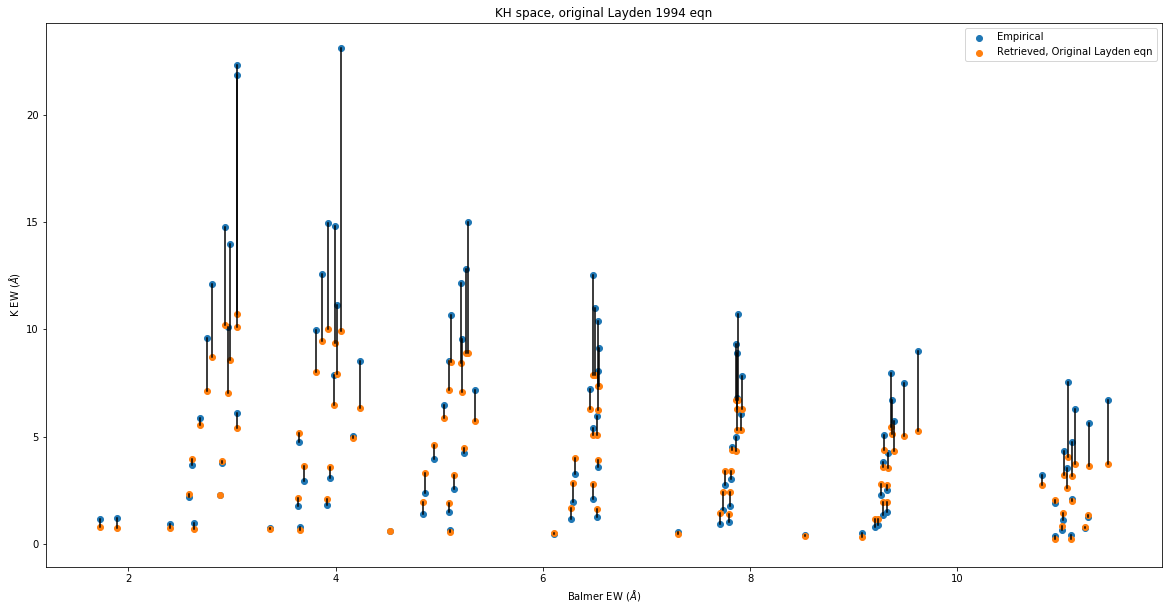

In [14]:
##########
# Fitting the data -- Least Squares Method
# Original Layden equation: K = a + b*H + c*F + d*H*F
##########

### USER INPUT HERE
df_choice = df

# define the fitting and error functions
fitfunc = lambda p, H, F: p[0] + p[1]*H + p[2]*F + p[3]*H*F
errfunc = lambda p, H, F, K, err_K: (K - fitfunc(p, H, F)) / err_K

#pinit = [13.5, -1., 4., -0.3]
pinit = [1., 1., 1., 1.]
out = optimize.leastsq(errfunc, pinit,
                       args=(df_choice["balmer"], df_choice["final_feh_center"], df_choice["K"], df_choice["err_K"]), full_output=1)

pfinal = out[0]
covar = out[1]
print(pfinal)
print(covar)

index = pfinal[1]
amp = 10.0**pfinal[0]

indexErr = np.sqrt( covar[1][1] )
ampErr = np.sqrt( covar[0][0] ) * amp

#####################
# calculate BIC
# N.b. astropy BIC assumes Gaussian distribution

# retrieved K values, using best-fit params
retrieved_K = fitfunc(pfinal, df_choice["balmer"], df_choice["final_feh_center"])

# 'sum of squared residuals between model and data'
ssr = np.sum(np.power(np.subtract(df_choice["K"],retrieved_K),2.))
n_params = len(pinit) # [a,b,c,d]
n_samples = len(df_choice["balmer"])

bic = astropy.stats.bayesian_info_criterion_lsq(ssr, n_params, n_samples)
print("----------")
print("BIC:")
print(bic)

#####################

plt.clf()
plt.figure(figsize=(20,10))

plt.scatter(df_choice["balmer"], df_choice["K"], label="Empirical")
plt.scatter(df_choice["balmer"], retrieved_K, 
            label="Retrieved, Original Layden eqn")
# connect the empirical-retrieved dots, using list comprehension
[plt.plot([df_choice["balmer"][j],df_choice["balmer"][j]],
          [df_choice["K"][j],retrieved_K[j]], color="k") for j in range(len(df_choice["final_feh_center"]))]
plt.ylabel("K EW ($\AA$)")
plt.xlabel("Balmer EW ($\AA$)")
plt.title("KH space, original Layden 1994 eqn")
plt.legend()
plt.savefig("junk_original_layden_KH.pdf")

In [ ]:
### Now going to second-order terms, there are 7 possible combinations of coefficients beyond [a,b,c,d]:
### [f], [g], [h], [f,g], [f,h], [g,h], [f,g,h]

In [3]:
# function to make the fit and save a plot
def function_fit(fitfunc, errfunc, pinit, df_choice, plot_title):
    out = optimize.leastsq(errfunc, pinit,
                       args=(df_choice["balmer"], df_choice["final_feh_center"], 
                             df_choice["K"], df_choice["err_K"]), full_output=1)
    #print(df_choice)
    #print(out)

    pfinal = out[0]
    covar = out[1]
    print("pfinal:")
    print(pfinal)
    print("covar:")
    print(covar)

    index = pfinal[1]
    amp = 10.0**pfinal[0]

    indexErr = np.sqrt( covar[1][1] )
    ampErr = np.sqrt( covar[0][0] ) * amp


    #####################
    # calculate BIC
    # N.b. astropy BIC assumes Gaussian distribution

    # retrieved K values, using best-fit params
    retrieved_K = fitfunc(pfinal, df_choice["balmer"], df_choice["final_feh_center"])

    # 'sum of squared residuals between model and data'
    ssr = np.sum(np.power(np.subtract(df_choice["K"],retrieved_K),2.))
    n_params = len(pinit) # [a,b,c,d] + ...
    n_samples = len(df_choice["balmer"])

    bic = astropy.stats.bayesian_info_criterion_lsq(ssr, n_params, n_samples)
    print("----------")
    print("BIC:")
    print(bic)

    #####################
    plt.clf()
    plt.figure(figsize=(20,10))
    plt.scatter(df_choice["balmer"], df_choice["K"], label="Empirical")
    plt.scatter(df_choice["balmer"], retrieved_K, 
            label="Retrieved, Modified Layden eqn")
    # connect the empirical-retrieved dots, using list comprehension
    [plt.plot([df_choice["balmer"][j],df_choice["balmer"][j]],
          [df_choice["K"][j],retrieved_K[j]], color="k") for j in range(len(df_choice["final_feh_center"]))]
    plt.ylabel("K EW ($\AA$)")
    plt.xlabel("Balmer EW ($\AA$)")
    plt.title(plot_title + ", BIC = " + str(bic))
    plt.legend()
    plt.savefig("junk.pdf")

# 0. Original Layden equation: [a,b,c,d]

pfinal:
[12.51368502 -0.78716519  3.87785117 -0.24297523]
covar:
[[ 0.27696558 -0.03022386  0.09594911 -0.01048706]
 [-0.03022386  0.00359208 -0.01048669  0.00125107]
 [ 0.09594911 -0.01048669  0.03393103 -0.00371694]
 [-0.01048706  0.00125107 -0.00371694  0.00044586]]
----------
BIC:
245.1464970126952


<Figure size 432x288 with 0 Axes>

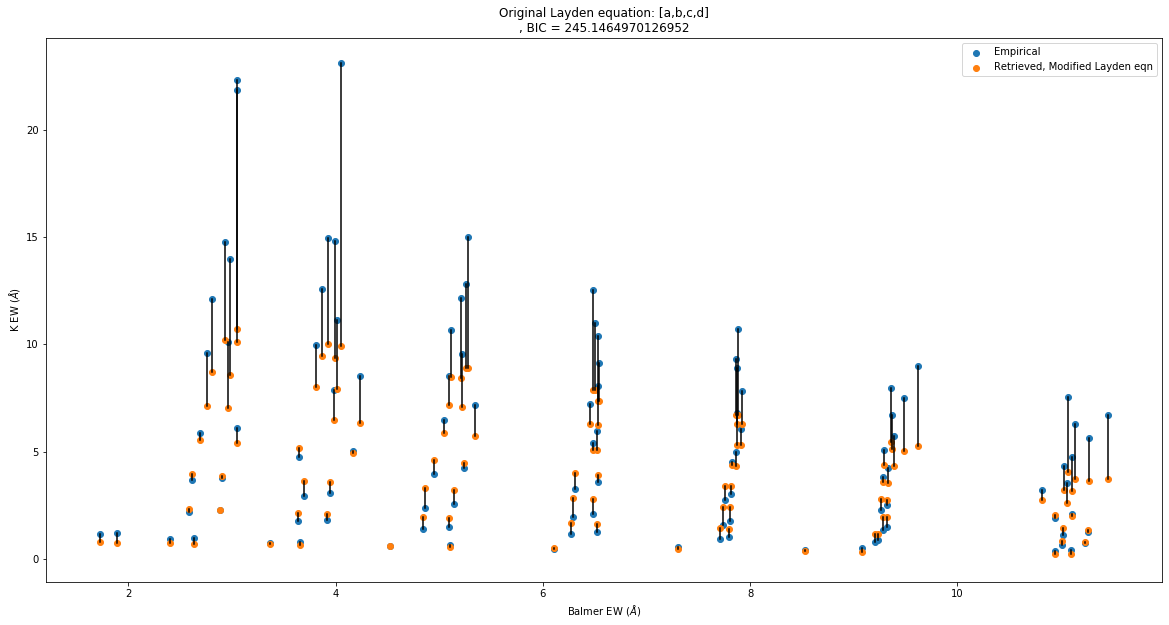

In [7]:
##########
# Fitting the data -- Least Squares Method
# Original Layden equation: K = a + b*H + c*F + d*H*F
##########

# define the fitting and error functions
fitfunc_abcd = lambda p, H, F: p[0] + p[1]*H + p[2]*F + p[3]*H*F 
errfunc_abcd = lambda p, H, F, K, err_K: (K - fitfunc_abcd(p, H, F)) / err_K

pinit_abcd = [1., 1., 1., 1.]

function_fit(fitfunc=fitfunc_abcd, 
             errfunc=errfunc_abcd, 
             pinit=pinit_abcd, 
             df_choice = df,
             plot_title="Original Layden equation: [a,b,c,d]\n")

# 7. Modified Layden equation: [a,b,c,d] + [f,g,h]

pfinal:
[16.92437966 -0.98640101  5.2261726   0.53344007 -0.06341921  0.27027538
 -0.02034332]
covar:
[[ 6.77490113e-01 -7.33191736e-02  2.33409257e-01  3.08185687e-02
  -5.76816105e-03  1.92716894e-02 -1.98216467e-03]
 [-7.33191736e-02  8.83451542e-03 -2.52510479e-02 -2.54878223e-03
   6.22975883e-04 -1.92185371e-03  2.14068993e-04]
 [ 2.33409257e-01 -2.52510479e-02  8.39325922e-02  1.00333098e-02
  -1.96421111e-03  6.79495219e-03 -6.98154697e-04]
 [ 3.08185687e-02 -2.54878223e-03  1.00333098e-02  5.46453091e-03
  -5.94835738e-04  2.12096521e-03 -2.00697711e-04]
 [-5.76816105e-03  6.22975883e-04 -1.96421111e-03 -5.94835738e-04
   8.31624422e-05 -2.76009460e-04  2.84520696e-05]
 [ 1.92716894e-02 -1.92185371e-03  6.79495219e-03  2.12096521e-03
  -2.76009460e-04  9.76067717e-04 -9.62811645e-05]
 [-1.98216467e-03  2.14068993e-04 -6.98154697e-04 -2.00697711e-04
   2.84520696e-05 -9.62811645e-05  9.92419144e-06]]
----------
BIC:
116.29437000510694


<Figure size 432x288 with 0 Axes>

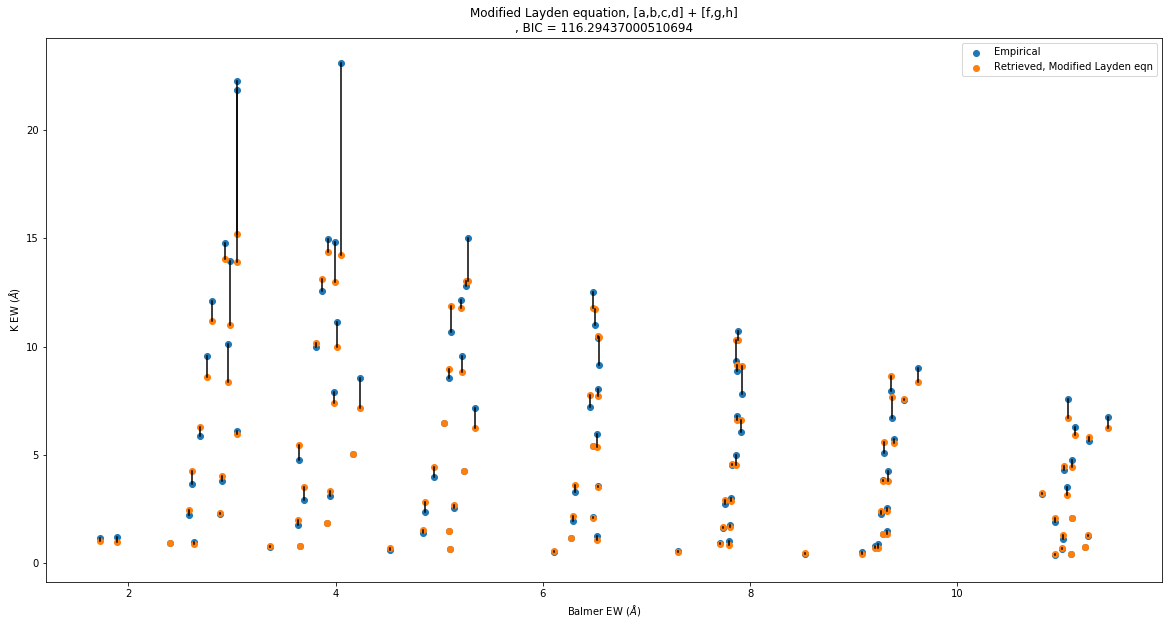

In [6]:
##########
# Fitting the data -- Least Squares Method
# Modified Layden equation: K = a + b*H + c*F + d*H*F + f*(H^2)*F + g*H*(F^2) + h*(H^2)*(F^2)
##########

### USER INPUT HERE
df_choice = df

# define the fitting and error functions
fitfunc_abcd_fgh = lambda p, H, F: p[0] + p[1]*H + p[2]*F + p[3]*H*F + p[4]*np.power(H,2.)*F + \
                            p[5]*H*np.power(F,2.) + p[6]*np.power(H*F,2.)
errfunc_abcd_fgh = lambda p, H, F, K, err_K: (K - fitfunc_abcd_fgh(p, H, F)) / err_K

pinit_abcd_fgh = [1., 1., 1., 1., 1., 1., 1.]

function_fit(fitfunc=fitfunc_abcd_fgh, 
             errfunc=errfunc_abcd_fgh, 
             pinit=pinit_abcd_fgh, 
             df_choice = df,
             plot_title="Modified Layden equation, [a,b,c,d] + [f,g,h]\n")

# 3. Modified Layden equation: [a,b,c,d] + [h]

pfinal:
[ 1.23984589e+01 -6.56536094e-01  3.45340519e+00 -6.63876729e-02
  3.19824476e-03]
covar:
[[ 2.77138087e-01 -3.04194202e-02  9.65845305e-02 -1.07514237e-02
  -4.78791672e-06]
 [-3.04194202e-02  3.81377721e-03 -1.12070439e-02  1.55076584e-03
   5.42795355e-06]
 [ 9.65845305e-02 -1.12070439e-02  3.62716390e-02 -4.69073774e-03
  -1.76367526e-05]
 [-1.07514237e-02  1.55076584e-03 -4.69073774e-03  8.50996189e-04
   7.33763905e-06]
 [-4.78791672e-06  5.42795355e-06 -1.76367526e-05  7.33763905e-06
   1.32894792e-07]]
----------
BIC:
226.17141772986807


<Figure size 432x288 with 0 Axes>

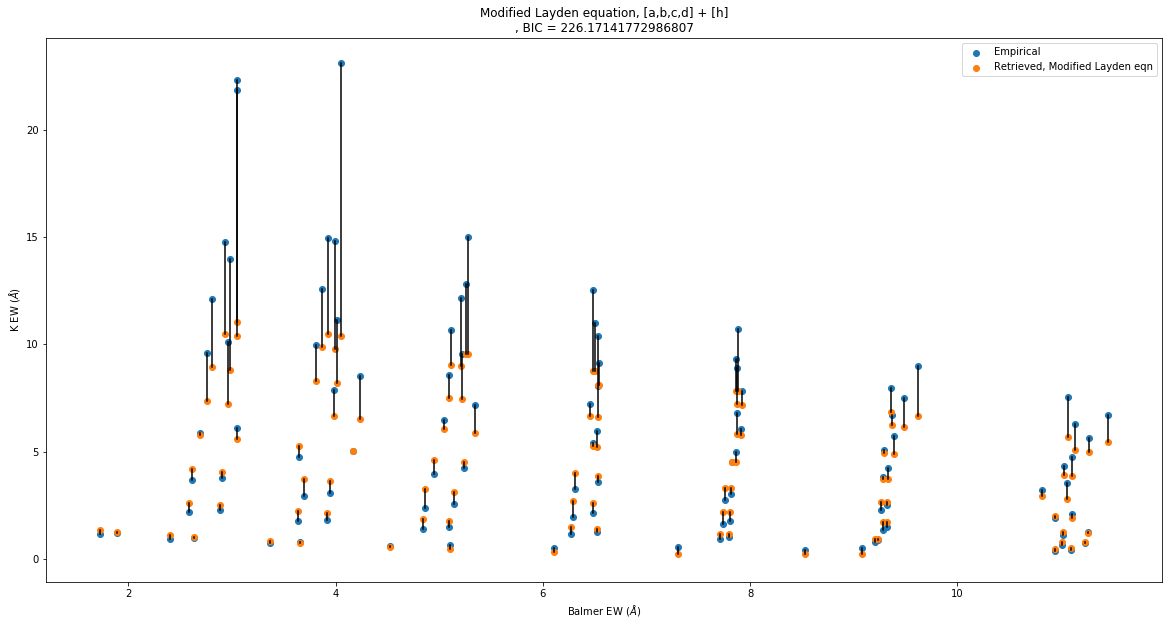

In [17]:
##########
# Fitting the data -- Least Squares Method
# Modified Layden equation: K = a + b*H + c*F + d*H*F + h*(H^2)*(F^2)
##########

### USER INPUT HERE
df_choice = df

# define the fitting and error functions
fitfunc_abcd_h = lambda p, H, F: p[0] + p[1]*H + p[2]*F + p[3]*H*F + p[4]*np.power(H*F,2.)
errfunc_abcd_h = lambda p, H, F, K, err_K: (K - fitfunc_abcd_h(p, H, F)) / err_K

pinit_abcd_h = [1., 1., 1., 1., 1.]

function_fit(fitfunc=fitfunc_abcd_h, 
             errfunc=errfunc_abcd_h, 
             pinit=pinit_abcd_h, 
             df_choice = df,
             plot_title="Modified Layden equation, [a,b,c,d] + [h]\n")

# 2. Modified Layden equation: [a,b,c,d] + [g]

pfinal:
[12.58779237 -0.51796907  3.91462516  0.05978479  0.07298478]
covar:
[[ 2.77008879e-01 -3.00666439e-02  9.59705967e-02 -1.03102421e-02
   4.26256955e-05]
 [-3.00666439e-02  4.16318165e-03 -1.04086724e-02  1.89337727e-03
   1.54838273e-04]
 [ 9.59705967e-02 -1.04086724e-02  3.39416867e-02 -3.62920021e-03
   2.11519614e-05]
 [-1.03102421e-02  1.89337727e-03 -3.62920021e-03  1.16825086e-03
   1.74143814e-04]
 [ 4.26256955e-05  1.54838273e-04  2.11519614e-05  1.74143814e-04
   4.19799392e-05]]
----------
BIC:
197.42180787854656


<Figure size 432x288 with 0 Axes>

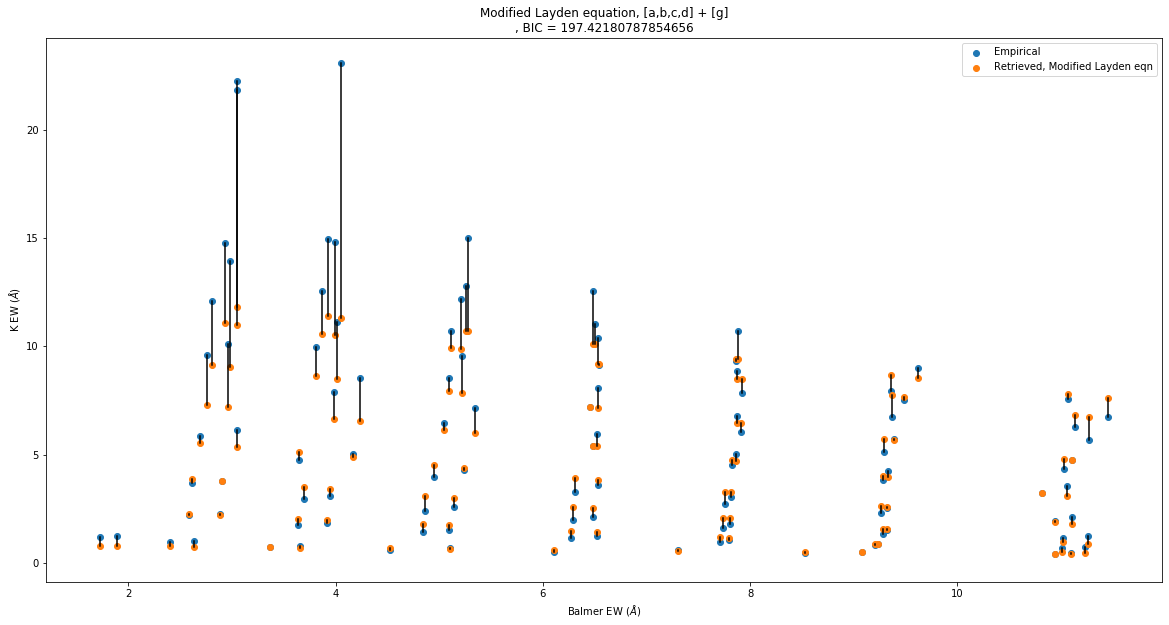

In [15]:
##########
# Fitting the data -- Least Squares Method
# Modified Layden equation: K = a + b*H + c*F + d*H*F + g*H*(F^2)
##########

### USER INPUT HERE
df_choice = df

# define the fitting and error functions
fitfunc_abcd_g = lambda p, H, F: p[0] + p[1]*H + p[2]*F + p[3]*H*F + \
                            p[4]*H*np.power(F,2.)
errfunc_abcd_g = lambda p, H, F, K, err_K: (K - fitfunc_abcd_g(p, H, F)) / err_K

pinit_abcd_g = [1., 1., 1., 1., 1.]

function_fit(fitfunc=fitfunc_abcd_g, 
             errfunc=errfunc_abcd_g, 
             pinit=pinit_abcd_g, 
             df_choice = df,
             plot_title="Modified Layden equation, [a,b,c,d] + [g]\n")

# 1. Modified Layden equation: [a,b,c,d] + [f]

pfinal:
[ 1.27893021e+01 -8.16741810e-01  3.75737333e+00 -1.79930750e-01
 -5.13597233e-03]
covar:
[[ 2.81550362e-01 -3.07158569e-02  9.39450152e-02 -9.43834488e-03
  -8.54348065e-05]
 [-3.07158569e-02  3.64487409e-03 -1.02716273e-02  1.13852874e-03
   9.16805550e-06]
 [ 9.39450152e-02 -1.02716273e-02  3.48070584e-02 -4.17535975e-03
   3.73452448e-05]
 [-9.43834488e-03  1.13852874e-03 -4.17535975e-03  6.85739693e-04
  -1.95422871e-05]
 [-8.54348065e-05  9.16805550e-06  3.73452448e-05 -1.95422871e-05
   1.59202928e-06]]
----------
BIC:
245.36213036898667


<Figure size 432x288 with 0 Axes>

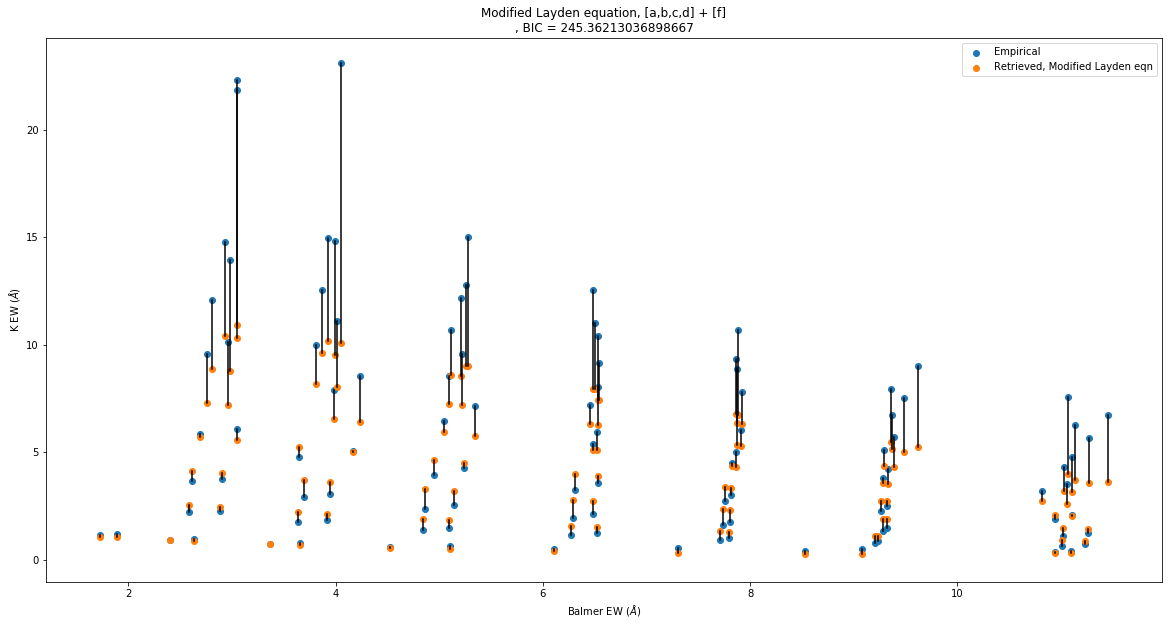

In [14]:
##########
# Fitting the data -- Least Squares Method
# Modified Layden equation: K = a + b*H + c*F + d*H*F + f*(H^2)*F
##########

### USER INPUT HERE
df_choice = df

# define the fitting and error functions
fitfunc_abcd_f = lambda p, H, F: p[0] + p[1]*H + p[2]*F + p[3]*H*F + p[4]*np.power(H,2.)*F 
errfunc_abcd_f = lambda p, H, F, K, err_K: (K - fitfunc_abcd_f(p, H, F)) / err_K

pinit_abcd_f = [1., 1., 1., 1., 1.]

function_fit(fitfunc=fitfunc_abcd_f, 
             errfunc=errfunc_abcd_f, 
             pinit=pinit_abcd_f, 
             df_choice = df,
             plot_title="Modified Layden equation, [a,b,c,d] + [f]\n")

# 6. Modified Layden equation: [a,b,c,d] + [g,h]

pfinal:
[ 1.25256126e+01 -5.11323159e-01  3.72827614e+00  7.98216085e-02
  5.97920771e-02  1.35407227e-03]
covar:
[[ 2.77409513e-01 -3.01094644e-02  9.71712473e-02 -1.04393400e-02
   1.27626227e-04 -8.72429083e-06]
 [-3.01094644e-02  4.16775834e-03 -1.05370005e-02  1.90717550e-03
   1.45753225e-04  9.32470833e-07]
 [ 9.71712473e-02 -1.05370005e-02  3.75399521e-02 -4.01609678e-03
   2.75893355e-04 -2.61461496e-05]
 [-1.04393400e-02  1.90717550e-03 -4.01609678e-03  1.20985114e-03
   1.46753237e-04  2.81131355e-06]
 [ 1.27626227e-04  1.45753225e-04  2.75893355e-04  1.46753237e-04
   6.00145192e-05 -1.85103340e-06]
 [-8.72429083e-06  9.32470833e-07 -2.61461496e-05  2.81131355e-06
  -1.85103340e-06  1.89986364e-07]]
----------
BIC:
203.0216458555668


<Figure size 432x288 with 0 Axes>

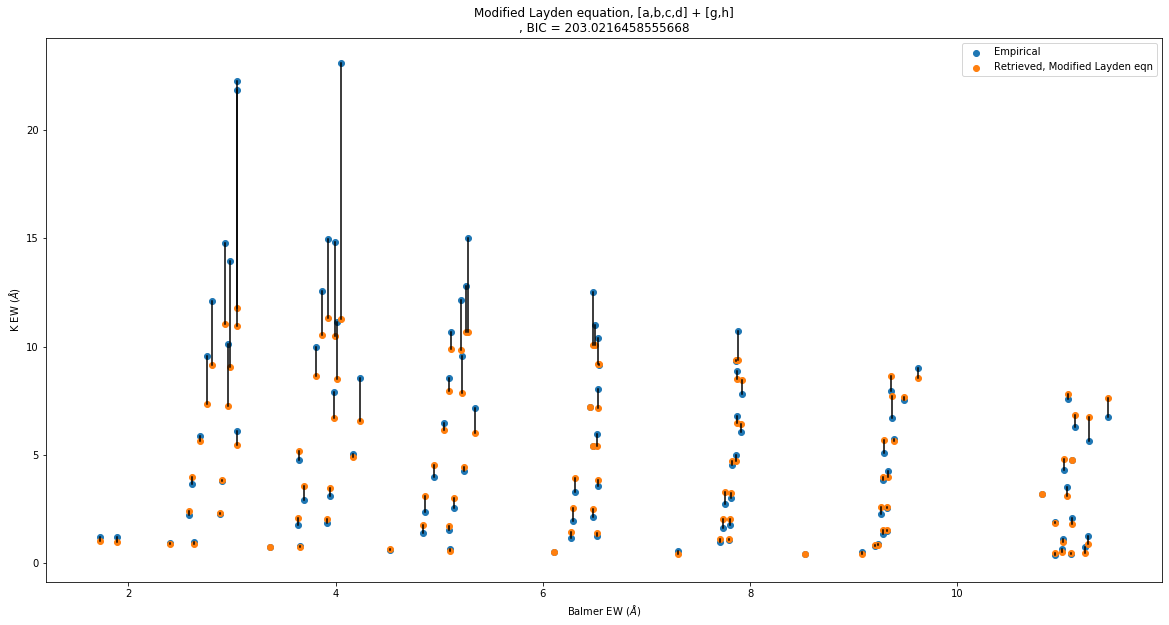

In [12]:
##########
# Fitting the data -- Least Squares Method
# Modified Layden equation: K = a + b*H + c*F + d*H*F + g*H*(F^2) + h*(H^2)*(F^2)
##########

### USER INPUT HERE
df_choice = df

# define the fitting and error functions
fitfunc_abcd_gh = lambda p, H, F: p[0] + p[1]*H + p[2]*F + p[3]*H*F +  \
                            p[4]*H*np.power(F,2.) + p[5]*np.power(H*F,2.)
errfunc_abcd_gh = lambda p, H, F, K, err_K: (K - fitfunc_abcd_gh(p, H, F)) / err_K

pinit_abcd_gh = [1., 1., 1., 1., 1., 1.]

function_fit(fitfunc=fitfunc_abcd_gh, 
             errfunc=errfunc_abcd_gh, 
             pinit=pinit_abcd_gh, 
             df_choice = df,
             plot_title="Modified Layden equation, [a,b,c,d] + [g,h]\n")

# 5. Modified Layden equation: [a,b,c,d] + [f,h]

pfinal:
[ 1.15880055e+01 -4.54235420e-01  3.34463488e+00 -5.38599946e-02
  1.30084276e-02  6.31715463e-03]
covar:
[[ 2.96985773e-01 -3.53736854e-02  9.92482766e-02 -1.10582227e-02
  -3.18571304e-04 -8.11688173e-05]
 [-3.53736854e-02  5.05043223e-03 -1.18719525e-02  1.62734714e-03
   7.95199266e-05  2.44937105e-05]
 [ 9.92482766e-02 -1.18719525e-02  3.66291401e-02 -4.73191329e-03
  -4.27552181e-05 -2.78877799e-05]
 [-1.10582227e-02  1.62734714e-03 -4.73191329e-03  8.55738628e-04
   4.92435829e-06  8.51830750e-06]
 [-3.18571304e-04  7.95199266e-05 -4.27552181e-05  4.92435829e-06
   5.11332509e-06  1.22597454e-06]
 [-8.11688173e-05  2.44937105e-05 -2.78877799e-05  8.51830750e-06
   1.22597454e-06  4.26835344e-07]]
----------
BIC:
226.36328694853378


<Figure size 432x288 with 0 Axes>

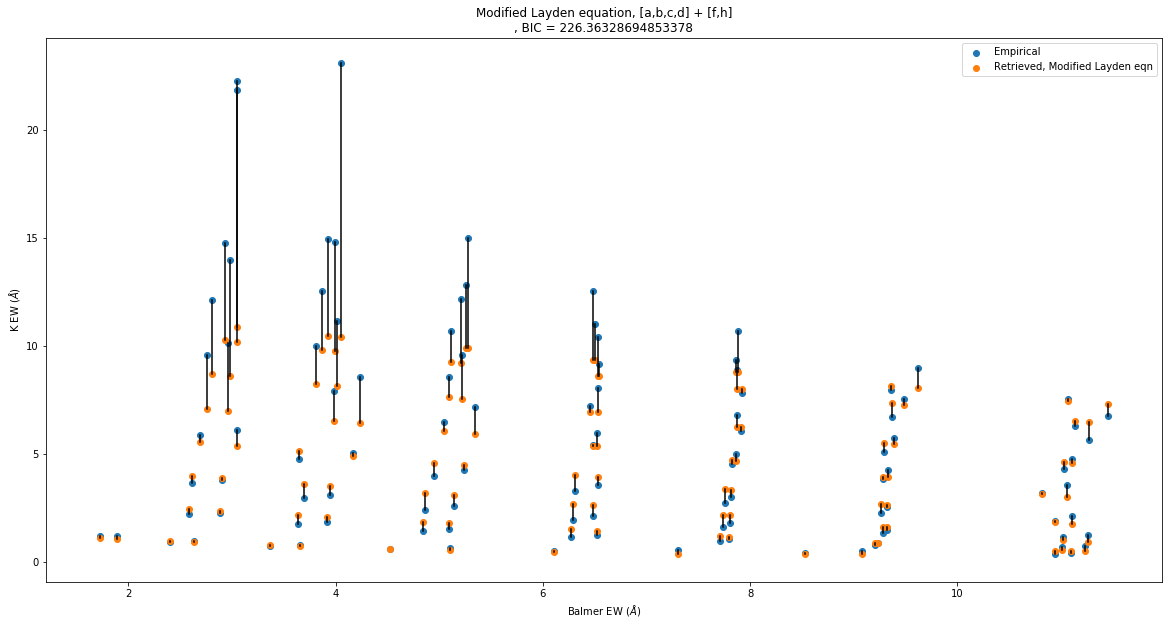

In [10]:
##########
# Fitting the data -- Least Squares Method
# Modified Layden equation: K = a + b*H + c*F + d*H*F + f*(H^2)*F + h*(H^2)*(F^2)
##########

### USER INPUT HERE
df_choice = df

# define the fitting and error functions
fitfunc_abcd_fh = lambda p, H, F: p[0] + p[1]*H + p[2]*F + p[3]*H*F + p[4]*np.power(H,2.)*F + \
                            p[5]*np.power(H*F,2.)
errfunc_abcd_fh = lambda p, H, F, K, err_K: (K - fitfunc_abcd_fh(p, H, F)) / err_K

pinit_abcd_fh = [1., 1., 1., 1., 1., 1.]

function_fit(fitfunc=fitfunc_abcd_fh, 
             errfunc=errfunc_abcd_fh, 
             pinit=pinit_abcd_fh, 
             df_choice = df,
             plot_title="Modified Layden equation, [a,b,c,d] + [f,h]\n")

# 4. Modified Layden equation: [a,b,c,d] + [f,g]

pfinal:
[ 1.28611965e+01 -5.47587058e-01  3.79504492e+00  1.22035564e-01
 -5.09612760e-03  7.29113430e-02]
covar:
[[ 2.81591159e-01 -3.05630437e-02  9.39663977e-02 -9.26690557e-03
  -8.54120946e-05  4.13949383e-05]
 [-3.05630437e-02  4.21695677e-03 -1.01915563e-02  1.78035214e-03
   9.25273069e-06  1.54971611e-04]
 [ 9.39663977e-02 -1.01915563e-02  3.48182645e-02 -4.08552854e-03
   3.73571429e-05  2.16902786e-05]
 [-9.26690557e-03  1.78035214e-03 -4.08552854e-03  1.40580541e-03
  -1.94472866e-05  1.73863603e-04]
 [-8.54120946e-05  9.25273069e-06  3.73571429e-05 -1.94472866e-05
   1.59204225e-06  2.29405653e-08]
 [ 4.13949383e-05  1.54971611e-04  2.16902786e-05  1.73863603e-04
   2.29405653e-08  4.19802750e-05]]
----------
BIC:
196.28752773438762


<Figure size 432x288 with 0 Axes>

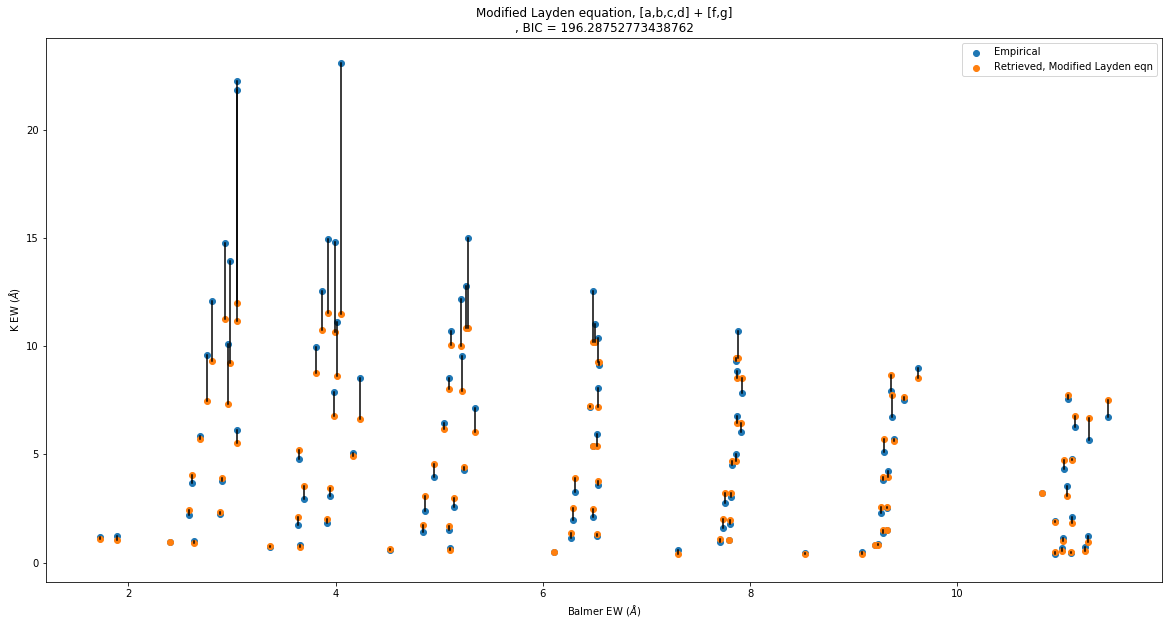

In [8]:
##########
# Fitting the data -- Least Squares Method
# Modified Layden equation: K = a + b*H + c*F + d*H*F + f*(H^2)*F + g*H*(F^2)
##########

### USER INPUT HERE
df_choice = df

# define the fitting and error functions
fitfunc_abcd_fg = lambda p, H, F: p[0] + p[1]*H + p[2]*F + p[3]*H*F + p[4]*np.power(H,2.)*F + \
                            p[5]*H*np.power(F,2.)
errfunc_abcd_fg = lambda p, H, F, K, err_K: (K - fitfunc_abcd_fg(p, H, F)) / err_K

pinit_abcd_fg = [1., 1., 1., 1., 1., 1.]

function_fit(fitfunc=fitfunc_abcd_fg, 
             errfunc=errfunc_abcd_fg, 
             pinit=pinit_abcd_fg, 
             df_choice = df,
             plot_title="Modified Layden equation, [a,b,c,d] + [f,g]\n")